Other useful information about this notebook:

- Filename: `dissipation-theory--Study-35.ipynb`
- Continued from: ---
- Continued to: ---

# Preliminaries

Load `numpy`, `pandas`, `matplotlib`, and objects and functions from `dissipationtheory`.

In [1]:
import numpy as np
import pandas

In [2]:
import matplotlib.pylab as plt
import seaborn as sns

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 2.5

from IPython.display import display, Markdown

In [3]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation4 import CantileverModel, SampleModel1
from dissipationtheory.dissipation4 import CantileverModelJit, SampleModel1Jit
from dissipationtheory.dissipation4 import theta1norm_jit, K_jit

In [4]:
THIS = 'dissipation-theory--Study-35--'
figs = {}

# Metal

Create a metallic sample.  Use typical cantilever parameters.  Compute $K_0$, $K_1$, and $K_2$ for various values of the charge location, $z_{\mathrm{c}}$.

In [5]:
def compute_K(omega_m, cantilever, sample):

    zc_array = np.logspace(np.log10(10), np.log10(1000), 11)

    K_dict = {
         'omega_m': omega_m,
         'zc': zc_array,
         '0': np.zeros_like(zc_array, dtype=complex),
         '1': np.zeros_like(zc_array, dtype=complex),
         '2': np.zeros_like(zc_array, dtype=complex),
         '0 calc': 1/(2 * zc_array),
         '1 calc': 1/(4 * zc_array**2),
         '2 calc': 2/(8 * zc_array**3)}

    for index, zc in enumerate(K_dict['zc']):

        cantilever.z_c = ureg.Quantity(zc, 'nm')
        sample.cantilever = cantilever
        sample1_jit = SampleModel1Jit(**sample.args())

        for key, number, unit in zip(['0', '1', '2'], [0, 1, 2], ['1/nm', '1/nm^2', '1/nm^3']):

            K_dict[key][index] = \
                K_jit(number, theta1norm_jit, sample1_jit, omega_m, False).to(unit).magnitude \
                + complex(0,1) * K_jit(number, theta1norm_jit, sample1_jit, omega_m, True).to(unit).magnitude

    return K_dict

Carry out the computation

In [6]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(5, 'nm'), 
    d = ureg.Quantity(10, 'nm'),
    z_c = ureg.Quantity(25, 'nm')  # placeholder
)

sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(1000, 'nm'),
    epsilon_s = ureg.Quantity(complex(1e6, 0), ''),
    sigma = ureg.Quantity(1e5, 'S/m'),
    rho = ureg.Quantity(1e27, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(73, 'nm')
)

In [7]:
sample1

cantilever

         resonance freq = 75.000 kHz
                        = 4.712e+05 rad/s
        spring constant = 2.800 N/m
     tip-sample voltage = 1.000 V
                 radius = 5.000 nm
                 height = 10.000 nm
  tip charge z location = 25.000 nm

semiconductor

             epsilon (real) = 1000000.000
             epsilon (imag) = 0.000
                  thickness = 1000.0 nm
               conductivity = 1.000e+05 S/m
             charge density = 1.000e+27 m^{-3}
           reference height = 7.300e+01 nm

         roll-off frequency = 1.129e+16 Hz
                   mobility = 6.242e-04 m^2/(V s)
         diffusion constant = 1.614e-05 m^2/s
               Debye length = 3.780e-02 nm
           diffusion length = 5.852e+03 nm
   effective epsilon (real) = 1000000.000
   effective epsilon (imag) = -23966804779.363

dielectric

  epsilon (real) = 1000000.000
  epsilon (imag) = 0.000
       thickness = infinite

In [8]:
K__ = {}
K__['metal 0'] = compute_K(0.001, cantilever, sample1)

Plot the $K_n$ calculation for $n = 1, 2, 3$ and plot these together with the image-charge calculation.  Plot the real and imaginary parts of the $K_n$ integrals.  Only plot the imaginary part if it's larger than 1 part per million of the real part, however.  

Compute the mean ratio of $\mathrm{Im}(K_0)/\mathrm{Re}(K_0)$.  It's a very small number for a metal.

In [9]:
np.abs((K__['metal 0']['0'].imag/K__['metal 0']['0'].real).mean())

4.436391358980954e-19

In [10]:
# A helper plotting function

def plotme(K_dict):
        
    sns.set_style('dark')
    
    fig, axs = plt.subplots(nrows=1, ncols=3,
        sharex=True, sharey = True,
        figsize=(6.50, 3.5)) 

    for number, key1, key2, unit in zip(
        [0, 1, 2],
        ['0 calc', '1 calc', '2 calc'],
        ['0', '1', '2'],
        ['1/nm', '1/nm$^2$', '1/nm$^3$']):

        axs[number].loglog(K_dict['zc'], K_dict[key1], 'k-', label='metal')
        axs[number].loglog(K_dict['zc'], K_dict[key2].real, 'b.-', label=f'$+$Re')

        mask = np.abs(K_dict[key2].imag/K_dict[key2].real) > 1e-6
        axs[number].loglog(K_dict['zc'][mask], -1 * K_dict[key2][mask].imag, 'g.-', label=f'$-$Im')        

        axs[number].set_title(f'$K_{number}$ [{unit}]', fontsize=12)
        axs[number].set_xlabel('$z_{\mathrm{c}}$ [nm]')

        # turn off fine ticks
        axs[number].yaxis.set_minor_locator(plt.NullLocator())
        axs[number].grid()

        axs[number].legend(fontsize=8, frameon=False, loc=3)

    fig.tight_layout()
    
    return fig

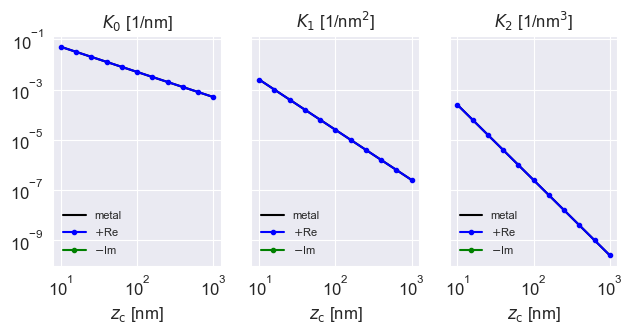

In [11]:
figs['01'] = plotme(K__['metal 0'])

Tabulate values of Re($K_n$) at 0.001 rad/s over a metal.

In [12]:
df = pandas.DataFrame.from_dict(
{'$10^{2} K_0$ [1/nm]':     1e2 * K__['metal 0']['0'].real,
 '$10^{3} K_1$ [1/nm$^2$]': 1e3 * K__['metal 0']['1'].real,
 '$10^{4} K_2$ [1/nm$^3$]': 1e4 * K__['metal 0']['2'].real})

markdown_table = df.to_markdown()
display(Markdown(markdown_table))

|    |   $10^{2} K_0$ [1/nm] |   $10^{3} K_1$ [1/nm$^2$] |   $10^{4} K_2$ [1/nm$^3$] |
|---:|----------------------:|--------------------------:|--------------------------:|
|  0 |             4.99999   |               2.5         |               2.5         |
|  1 |             3.15478   |               0.995266    |               0.62797     |
|  2 |             1.99053   |               0.396223    |               0.157739    |
|  3 |             1.25594   |               0.157739    |               0.0396223   |
|  4 |             0.792446  |               0.0627971   |               0.00995267  |
|  5 |             0.5       |               0.025       |               0.0025      |
|  6 |             0.315479  |               0.00995267  |               0.000627971 |
|  7 |             0.199054  |               0.00396223  |               0.000157739 |
|  8 |             0.125594  |               0.00157739  |               3.96223e-05 |
|  9 |             0.0792447 |               0.000627972 |               9.95268e-06 |
| 10 |             0.05      |               0.00025     |               2.5e-06     |

# Semiconductor

Now repeat the calculation for a semiconductor sample, and pick an $\omega_{\mathrm{m}}$ in the middle of the BLDS spectrum.

In [13]:
sample2 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(500, 'nm'),
    epsilon_s = ureg.Quantity(complex(3.00, -0.3), ''),
    sigma = ureg.Quantity(1e-8, 'S/cm'),
    rho = ureg.Quantity(1e14, '1/cm^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(500, 'nm')
)

In [14]:
sample2

cantilever

         resonance freq = 75.000 kHz
                        = 4.712e+05 rad/s
        spring constant = 2.800 N/m
     tip-sample voltage = 1.000 V
                 radius = 5.000 nm
                 height = 10.000 nm
  tip charge z location = 1000.000 nm

semiconductor

             epsilon (real) = 3.000
             epsilon (imag) = -0.300
                  thickness = 500.0 nm
               conductivity = 1.000e-06 S/m
             charge density = 1.000e+20 m^{-3}
           reference height = 5.000e+02 nm

         roll-off frequency = 1.129e+05 Hz
                   mobility = 6.242e-08 m^2/(V s)
         diffusion constant = 1.614e-09 m^2/s
               Debye length = 1.195e+02 nm
           diffusion length = 5.852e+01 nm
   effective epsilon (real) = 3.000
   effective epsilon (imag) = -0.540

dielectric

  epsilon (real) = 1000000.000
  epsilon (imag) = 0.000
       thickness = infinite

## Plot

Compute the $K_{n}$'s at three frequencies: 

* $0.001 \: \mathrm{rad/s}$, approximately zero frequency; 
* $1.129 \times 10^5 \: \mathrm{rad/s}$, the roll-off frequency;  and
* $1.129 \times 10^8 \: \mathrm{rad/s}$, a factor of $10^{3}$ above the roll-off frequency.

The $K_{n}$'s are not visibly different at the three frequencies.  So save only the low-frequency plot.

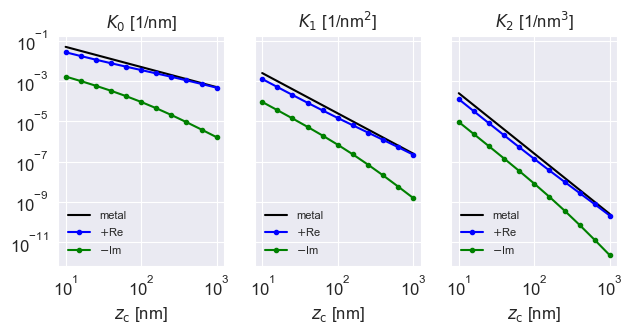

In [15]:
K__['semi low'] = compute_K(0.001, cantilever, sample2)
figs['02'] = plotme(K__['semi low'])

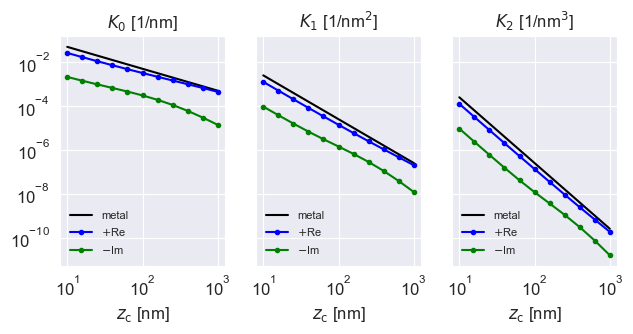

In [16]:
K__['semi med'] = compute_K(1.129e+05, cantilever, sample2)
_ = plotme(K__['semi med'])

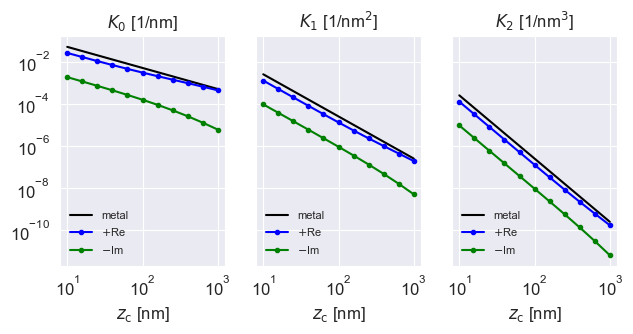

In [17]:
K__['semi high'] = compute_K(1.129e+08, cantilever, sample2)
_ = plotme(K__['semi high'])

## Tabulate $K_n$

The integrals $K_n$ do change with frequency, but the change is subtle.  See this by tabulating values. First tabulate Re($K_0$) over a semiconductor at selected $\omega_{\mathrm{m}}$ values. 

In [18]:
dgr = pandas.DataFrame.from_dict(
{r'$10^{-3}$ rad/s':          K__['semi low']['0'].real,
 r'$1.129$$\times$$10^{5}$ rad/s': K__['semi med']['0'].real,
 r'$1.129$$\times$$10^{8}$ rad/s': K__['semi high']['0'].real})

display(Markdown(dgr.to_markdown()))

|    |   $10^{-3}$ rad/s |   $1.129$$\times$$10^{5}$ rad/s |   $1.129$$\times$$10^{8}$ rad/s |
|---:|------------------:|--------------------------------:|--------------------------------:|
|  0 |       0.0269042   |                     0.0263571   |                     0.0257341   |
|  1 |       0.0175279   |                     0.0170012   |                     0.0164483   |
|  2 |       0.011549    |                     0.0110524   |                     0.0105827   |
|  3 |       0.007703    |                     0.00724919  |                     0.00687175  |
|  4 |       0.00519508  |                     0.00479901  |                     0.00451578  |
|  5 |       0.00352967  |                     0.00320545  |                     0.00300929  |
|  6 |       0.00240156  |                     0.00215768  |                     0.00203312  |
|  7 |       0.00162533  |                     0.00145994  |                     0.00138731  |
|  8 |       0.00108823  |                     0.000988314 |                     0.000949077 |
|  9 |       0.000718992 |                     0.000665182 |                     0.000645354 |
| 10 |       0.000468967 |                     0.000442763 |                     0.000433324 |

Second, tabulate $-$Im($K_0$) over a semiconductor at selected $\omega_{\mathrm{m}}$ values. 

In [19]:
dgi = pandas.DataFrame.from_dict(
{r'$10^{-3}$ rad/s': -K__['semi low']['0'].imag,
 r'$1.129$$\times$$10^5$ rad/s': -K__['semi med']['0'].imag,
 r'$1.129$$\times$$10^8$ rad/s': -K__['semi high']['0'].imag})

display(Markdown(dgi.to_markdown()))

|    |   $10^{-3}$ rad/s |   $1.129$$\times$$10^5$ rad/s |   $1.129$$\times$$10^8$ rad/s |
|---:|------------------:|------------------------------:|------------------------------:|
|  0 |       0.00167866  |                   0.00212522  |                   0.00183191  |
|  1 |       0.00100354  |                   0.00142439  |                   0.00114257  |
|  2 |       0.000585437 |                   0.000970194 |                   0.000707883 |
|  3 |       0.000330478 |                   0.000667298 |                   0.00043414  |
|  4 |       0.000178866 |                   0.00045662  |                   0.000262244 |
|  5 |       9.20451e-05 |                   0.000303861 |                   0.000154953 |
|  6 |       4.48154e-05 |                   0.000191596 |                   8.87834e-05 |
|  7 |       2.06752e-05 |                   0.000112027 |                   4.88513e-05 |
|  8 |       9.11825e-06 |                   6.01414e-05 |                   2.55844e-05 |
|  9 |       3.8944e-06  |                   2.97696e-05 |                   1.26842e-05 |
| 10 |       1.62915e-06 |                   1.37803e-05 |                   5.95423e-06 |

# Save all figures

In [20]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].tight_layout()
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')